In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import matplotlib.ticker as ticker

In [2]:
cal_file1 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam1pixel.h5'
cal_file2 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam2pixel.h5'

In [3]:
t_hor = 5010;
lambda_min = 7;
lambda_max = 13;
waves = np.linspace(7,12,120)
A_ne = 4.0832;
B_ne = 2.0041;
C_ne = .20646;
D_ne = 3.9928;
E_ne = 3866.92;
A_no = 4.1318;
B_no = 1.8584;
C_no = .21999;
D_no = 2.76773;
E_no = 2962.98;
def retardance(wavelength):
    ne = np.sqrt(A_ne + (B_ne*wavelength**2)/(wavelength**2 - C_ne) + (D_ne*wavelength**2)/(wavelength**2 - E_ne));
    no = np.sqrt(A_no + (B_no*wavelength**2)/(wavelength**2 - C_no) + (D_no*wavelength**2)/(wavelength**2 - E_no)); 
    b = ne - no; 

    retardance = (b*t_hor);
    return retardance

In [4]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [5]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

In [6]:
calibration_path =  'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\'

In [7]:
a_file = h5py.File(calibration_path+ 'calibration.h5', "r")
print(a_file.keys())
a_file.close()

<KeysViewHDF5 ['pixel', 'polarization', 'radiometric', 'transmission']>


In [8]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    lambda_c = file['/pixel/wavelength'][()]
    pixel1 = file['/pixel/pixel1'][()]
    pixel2 = file['/pixel/pixel2'][()]

In [191]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return([I1,I2])


def MOD(a,band):
#calculate modulation function for calibration data
    i = band

    start = pixel1[i]
    stop  = pixel2[i]
    I1 = R1[a,start:stop]/t_unpol[start:stop]
    I2 = R2[a,start:stop]
    
    e1 = E1[a,start:stop]
    e2 = E2[a,start:stop]
    
    I1,I2 = transmission_correction(I1,I2,15)

    mod_a = (I1-I2)/(I1+I2)
    mod_e = (e1+e2)/(I1+I2)
                            
    return([mod_a,mod_e])

In [192]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//DryIce.6.5.2023//'
angles = np.arange(0, 60,10)
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,256,320])
imgs2 = np.zeros([num,256,320])
imgs3 = np.zeros([num,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)


for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
    with h5py.File(path + str(angles[i]) + str('deg.h5'), "r") as f:
            #print(f.keys())
            imgs1[i] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
            imgs2[i] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
            imgs3[i] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
            std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
            std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
            t1[i] = np.array(f[list(f.keys())[7]])
            t2[i] = np.array(f[list(f.keys())[8]])
            t3[i] = np.array(f[list(f.keys())[9]])


In [193]:
xmin1 = 105; xmax1 = 170; #active region
ymin1 = 95; ymax1 = 138;
xmin2 = 105; xmax2 = 165;
ymin2 = 110; ymax2 = 150;

FOV = 5.33
HFOV = FOV/4

In [194]:
im1 = []
im2 = []
for t in range(num):
    
    c1 = (imgs1[t] - np.mean(imgs1[t][160:170,145:155]))    
    c2 = (imgs2[t] - np.mean(imgs2[t][200:256,120:160]))    
    
    
    im1.append(c1)
    im2.append(c2)

In [195]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [196]:
#p1 = pixel_registration(im1[0],cal_file1,waves,0,320)
#p2 = pixel_registration(im2[0],cal_file2,waves,0,320)
#plt.plot(np.sum(p1,axis = 1))
#plt.show()
#plt.plot(np.sum(p2,axis = 1))
#plt.show()
#y2 = np.argmax(np.sum(p2,axis = 1))
#y1 = np.argmax(np.sum(p1,axis = 1))
y2 = 131
y1 = 118

In [197]:
responses = np.zeros([len(angles),len(waves)])
responses1 = np.zeros([len(angles),len(waves)])
responses2 = np.zeros([len(angles),len(waves)])
responses_err = np.zeros([len(angles),len(waves)])
responses_err1 = np.zeros([len(angles),len(waves)])
responses_err2 = np.zeros([len(angles),len(waves)])

for a in range(len(angles)):
    p2 = pixel_registration(im2[a],cal_file2,waves,ymin2,ymax2)
    p1 = pixel_registration(im1[a],cal_file1,waves,ymin1,ymax1)
    s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
    s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

    err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
    responses[a]= (p1[y1-ymin1]+p2[y2-ymin2])
    responses_err[a]= err
    
    responses1[a]= p1[y1-ymin1]
    responses_err1[a]= s1[y1-ymin1]
    responses2[a]= p2[y2-ymin2]
    responses_err2[a]= s2[y2-ymin2]

In [198]:
R1 = responses1
R2 = responses2
E1 = responses_err1
E2 = responses_err2

In [199]:
from astropy.timeseries import LombScargle
wavenums = np.divide(1,np.multiply(lambda_c,1e-4))

with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    carrier = file['/polarization/carrier'][()]
    W = file['/polarization/W'][()]
    W_ang = file['/polarization/W_ang'][()]
    phase = file['/polarization/phase'][()]
    wavnums = file['/polarization/wavenums'][()]
    aolp_cal =  file['/polarization/aolp'][()]
    dolp_cal =  file['/polarization/dolp'][()]
    dolp_error =  file['/polarization/dolp'][()]
    t_unpol =  file['/transmission/t_unpol'][()]
    t_pol = file['/transmission/t_pol'][()]

40
8.008403361344538
prob = 5.043618927199608e-06
best freq = 0.009314673688150777
dolp = 1.397030007150433
aolp = -0.5905969422975137


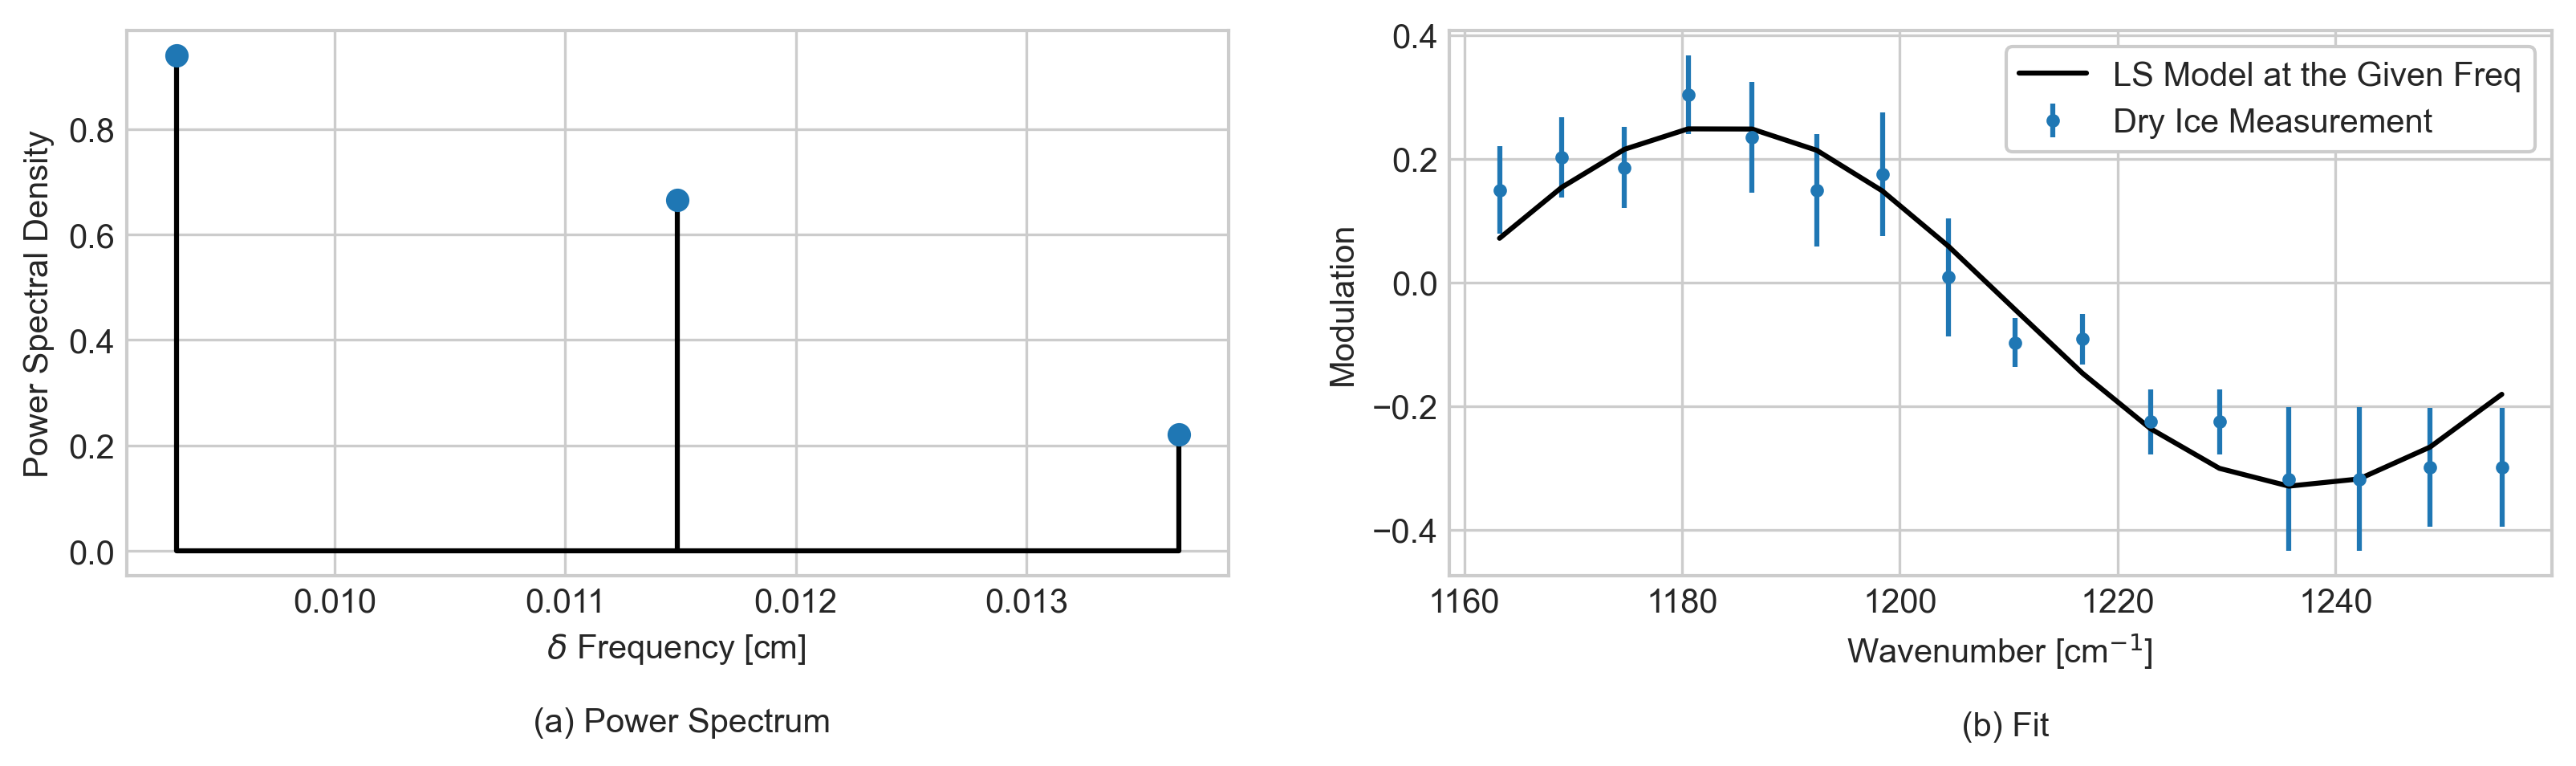

In [200]:
plt.style.use('seaborn-whitegrihttp://localhost:8889/notebooks/Documents/Summer2022Campaign/IRCSP1/Calibration/practice_retrieval.ipynb#d')

a = 4
j = 17
print(angles[a])
print(lambda_c[j])
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
freq = carrier[j]


x = wavenums[start:stop]
[y,dy] = MOD(a,j)



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=carrier[j]-.002,
                                    maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('prob = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))


[offset,q,u] = ls.model_parameters(freq)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

50
9.184873949579831
prob = 0.00011177008979473615
best freq = 0.011757031490773971
dolp = 1.186337567551292
aolp = -1.556715436322415


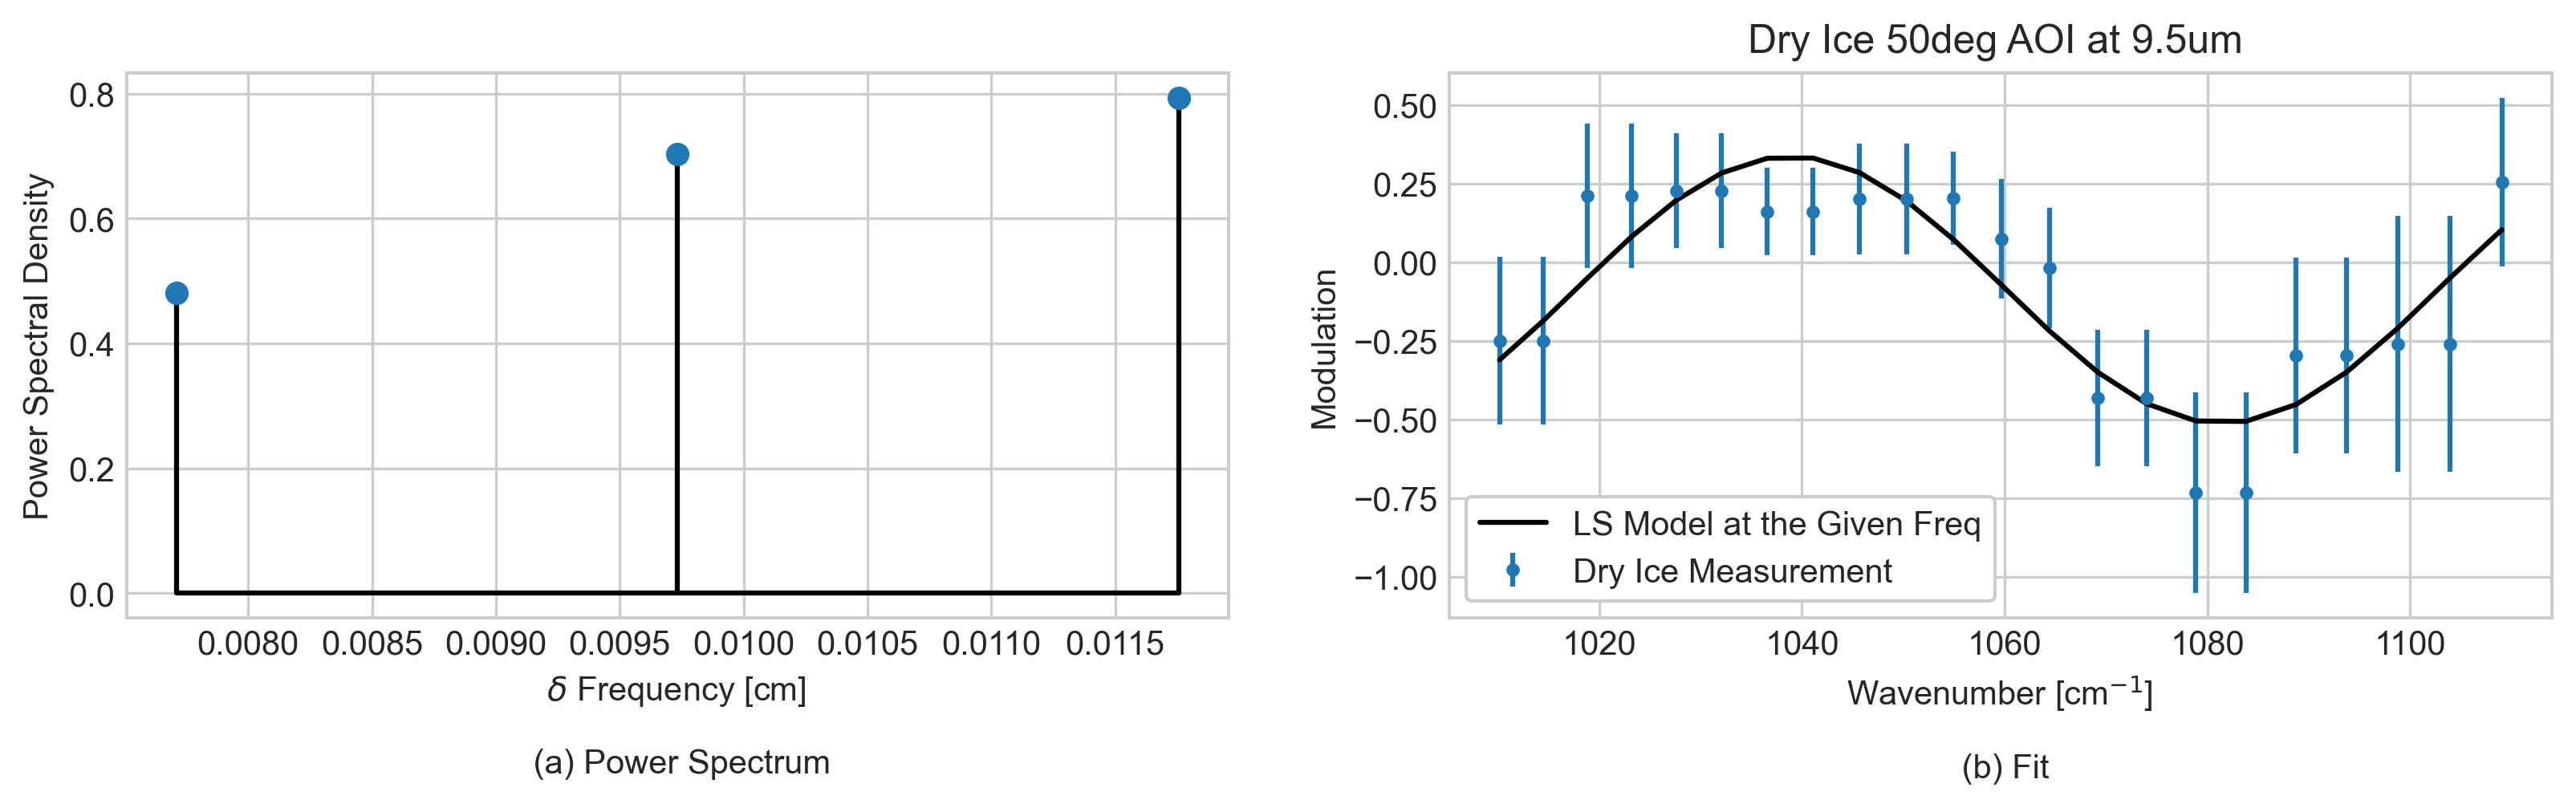

In [201]:
a = 5
j = 45
print(angles[a])
print(lambda_c[j])
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;


x = wavenums[start:stop]
[y,dy] = MOD(a,j)



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=carrier[j]-.002,
                                    maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('prob = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))


[offset,q,u] = ls.model_parameters(freq)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
axes[1].set_title('Dry Ice 50deg AOI at 9.5um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

AOI = 40
wavelength = 9.521008403361344
False Alarm Probability = 0.0014950518054555138
best freq = 0.01128096537138495
dolp = 0.40401574883656666
aolp = -1.4623732917233758


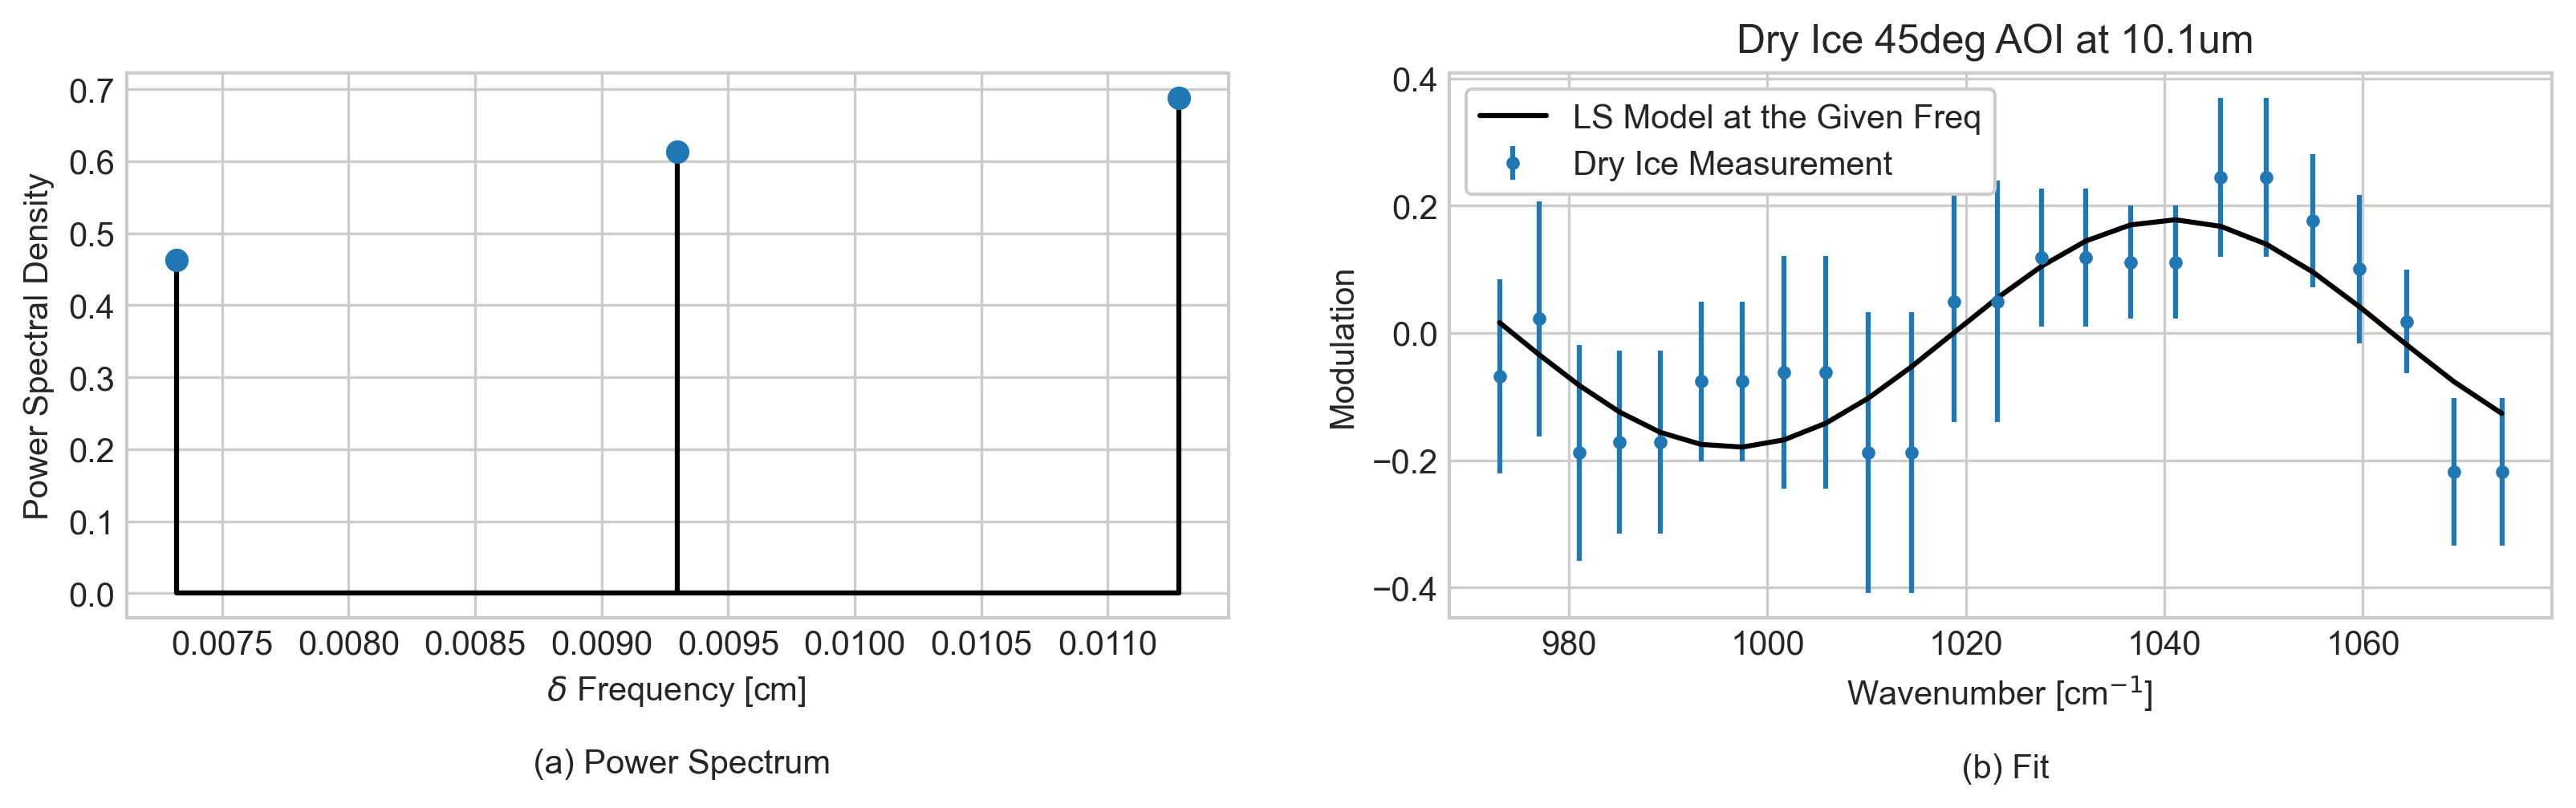

In [202]:

a = 4
j = 53
print('AOI = ' + str(angles[a]))
print('wavelength = ' + str(lambda_c[j]))
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
freq = carrier[j]

x = wavenums[start:stop]
[y,dy] = MOD(a,j)



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=carrier[j]-.002,
                                    maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('False Alarm Probability = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))
[offset,q,u] = ls.model_parameters(freq)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
axes[1].set_title('Dry Ice 45deg AOI at 10.1um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [103]:
def LombModel(a,j,thresh,W):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]

    x = wavnums[start:stop]
    [y,dy] = MOD(a,j)

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    best_frequency = frequency[np.argmax(power)]
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(freq)
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        aolp_corr = aolp - phase[j]
        idx = find_nearest(W_ang, aolp_corr)
        eff = W[j,idx]
        dolp_corr = dolp/eff
        if dolp > 1:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]
            
    else:
        [prob,U,Q,dolp_corr,aolp_corr,offset] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp_corr,aolp_corr,Q,U,prob,offset])

# Radiometry

In [152]:
LUT = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//LUT//'

In [41]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//DryIce.6.10.2023//'

In [154]:
temps = np.arange(10, 150,5)
num = len(temps)
imgs1 = np.zeros([numtemps,256,320])
imgs2 = np.zeros([numtemps,256,320])
std1 = np.zeros([numtemps,256,320])
std2 = np.zeros([numtemps,256,320])
t1 = np.zeros(numtemps)
t2 = np.zeros(numtemps)

for i in range(num):
    with h5py.File(LUT + str(round(temps[i],3))+'C.h5', "r") as f:
        imgs1[i] = np.mean(np.array(f[list(f.keys())[2]]),axis = 0)
        imgs2[i] = np.mean(np.array(f[list(f.keys())[3]]),axis = 0)
        std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis=0)
        std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
        t1[i] = np.array(f[list(f.keys())[7]])
        t2[i] = np.array(f[list(f.keys())[8]])

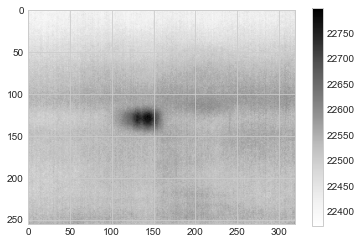

In [43]:
plt.imshow(imgs2[-1])
plt.colorbar()

In [56]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//DryIce.6.10.2023//'
angles = np.arange(-60, 60,5)
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,256,320])
imgs2 = np.zeros([num,256,320])
imgs3 = np.zeros([num,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)


for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
    with h5py.File(path + str(angles[i]) + str('deg.h5'), "r") as f:
            #print(f.keys())
            imgs1[i] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
            imgs2[i] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
            imgs3[i] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
            std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
            std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
            t1[i] = np.array(f[list(f.keys())[7]])
            t2[i] = np.array(f[list(f.keys())[8]])
            t3[i] = np.array(f[list(f.keys())[9]])


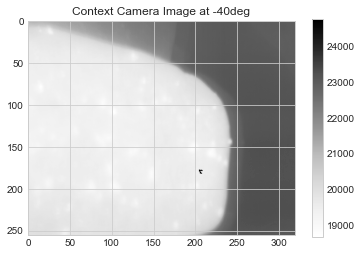

In [57]:
i = 4
plt.imshow(imgs3[i])
plt.title("Context Camera Image at " + str(angles[i]) + "deg")
plt.colorbar()

In [160]:
im1 = []
im2 = []
for t in range(num):
    
    c1 = (imgs1[t] - np.mean(imgs1[t][160:190,130:155]))    
    c2 = (imgs2[t] - np.mean(imgs2[t][230:256,120:160]))    
    
    im1.append(c1)
    im2.append(c2)

In [156]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [157]:
#p1 = pixel_registration(im1[-1],cal_file1,waves,0,320)
#p2 = pixel_registration(im2[-1],cal_file2,waves,0,320)
#plt.plot(np.sum(p1,axis = 1))
#plt.show()
#plt.plot(np.sum(p2,axis = 1))
#plt.show()
#y2 = np.argmax(np.sum(p2,axis = 1))
#y1 = np.argmax(np.sum(p1,axis = 1))
y2 = 129
y1 = 116

In [158]:
np.shape(im1)

(6, 256, 320)

In [161]:
responses = np.zeros([num,len(waves)])
responses1 = np.zeros([num,len(waves)])
responses2 = np.zeros([num,len(waves)])
responses_err = np.zeros([num,len(waves)])
responses_err1 = np.zeros([num,len(waves)])
responses_err2 = np.zeros([num,len(waves)])

for t in range(num):
    p2 = pixel_registration(im2[t],cal_file2,waves,ymin2,ymax2)
    p1 = pixel_registration(im1[t],cal_file1,waves,ymin1,ymax1)
    s2 = pixel_registration(std2[t],cal_file2,waves,ymin2,ymax2)
    s1 = pixel_registration(std1[t],cal_file1,waves,ymin1,ymax1)

    err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
    responses[t]= (p1[y1-ymin1]+p2[y2-ymin2])
    responses_err[t]= err

    responses1[t]= p1[y1-ymin1]
    responses_err1[t]= s1[y1-ymin1]
    responses2[t]= p2[y2-ymin2]
    responses_err2[t]= s2[y2-ymin2]

In [63]:
""" Fitting Function"""
def func(x, a, b):
    y = (x/a)**0.25 +b
    return y

with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    nedt = file['/radiometric/nedt'][()]
    var = file['/radiometric/var'][()]

In [162]:
R1 = responses1
R2 = responses2
E1 = responses_err1
E2 = responses_err2

In [83]:
#t_pol[find_nearest(aolp[j,a],cal_angles),j]*(1-dolp[j,a])

In [77]:
def get_BT(j,i,f):
    bt = []
    Et = []
    for a in range(i,f):
        start = pixel1[j]
        stop  = pixel2[j]
       # corr = t_pol[find_nearest(aolp[j,a],cal_angles),j]*(1-dolp[j,a])
        response = np.sum(R1[a,start:stop]+R2[a,start:stop])
        response_err = np.sum(E1[a,start:stop]+E2[a,start:stop])
        bt.append(func(response,var[j,0],var[j,1]))
        Et.append(func(response+response_err/2,var[j,0],var[j,1])-func(response-response_err/2,var[j,0],var[j,1]))
    return([bt,Et])

In [74]:
np.shape(R1)

(24, 120)

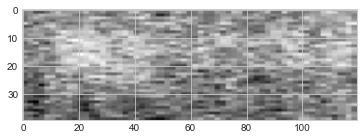

In [71]:
plt.imshow(p2)

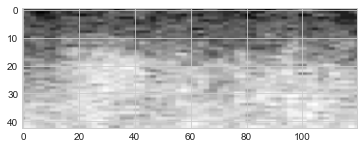

In [72]:
plt.imshow(p1)

In [78]:
ii = 0
ff = num
bt1 = np.zeros([num,10])
bt2 = np.zeros([num,10])
bt3 = np.zeros([num,10])
bt4 = np.zeros([num,10])

for l in range(10):
    bt1[:,l] = get_BT(17,ii,ff)[0]
    bt2[:,l] = get_BT(53,ii,ff)[0]
    bt3[:,l] = get_BT(67,ii,ff)[0]
    bt4[:,l] = get_BT(94,ii,ff)[0]

In [79]:
xmin1 = 100; xmax1 = 180; #active region
ymin1 = 100; ymax1 = 140;
xmin2 = 100; xmax2 = 180;
ymin2 = 105; ymax2 = 150;

Text(0, 0.5, 'Brightness Temperature Retrieval')

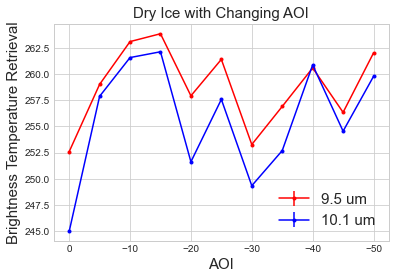

In [80]:
#plt.errorbar(angles[2:13],np.mean(bt1,axis=1)[2:13],marker = '.',yerr=np.std(bt1,axis=1)[2:13],color = 'g',label = '8 um')
plt.errorbar(angles[2:13],np.mean(bt2,axis=1)[2:13],marker='.',yerr=np.std(bt2,axis=1)[2:13],color = 'r',label = '9.5 um')
plt.errorbar(angles[2:13],np.mean(bt3,axis=1)[2:13],marker='.',yerr=np.std(bt3,axis=1)[2:13],color = 'b',label = '10.1 um')
#plt.errorbar(capture,np.mean(bt4,axis=1),marker='.',yerr=np.std(bt4,axis=1),color = 'blue',label = '10.4um')
plt.legend(fontsize=15)
plt.title("Dry Ice with Changing AOI",fontsize=15)
plt.xlabel("AOI",fontsize=15)
plt.gca().invert_xaxis()

plt.ylabel("Brightness Temperature Retrieval",fontsize=15)
#plt.ylim(284,305)

Text(0, 0.5, 'Brightness Temperature Retrieval')

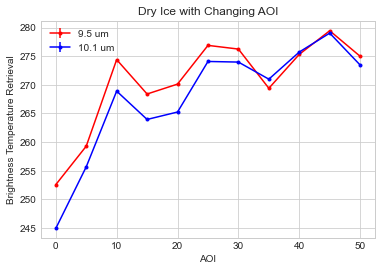

In [81]:
#plt.errorbar(angles[12:23],np.mean(bt1,axis=1)[12:23],marker = '.',yerr=np.std(bt1,axis=1)[12:23],color = 'g',label = '8 um')
plt.errorbar(angles[12:23],np.mean(bt2,axis=1)[12:23],marker='.',yerr=np.std(bt2,axis=1)[12:23],color = 'r',label = '9.5 um')
plt.errorbar(angles[12:23],np.mean(bt3,axis=1)[12:23],marker='.',yerr=np.std(bt3,axis=1)[12:23],color = 'b',label = '10.1 um')
#plt.errorbar(capture,np.mean(bt4,axis=1),marker='.',yerr=np.std(bt4,axis=1),color = 'blue',label = '10.4um')
plt.legend()
plt.title("Dry Ice with Changing AOI")
plt.xlabel("AOI")

plt.ylabel("Brightness Temperature Retrieval")
#plt.ylim(284,305)

Text(0, 0.5, 'Brightness Temperature Retrieval')

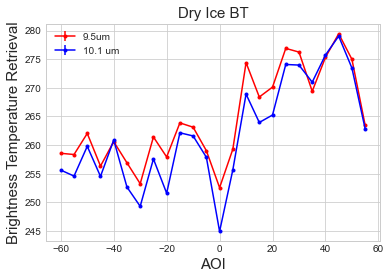

In [82]:
#plt.errorbar(angles,np.mean(bt1,axis=1),marker = '.',yerr=np.std(bt1,axis=1),color = 'green',label = '8 um')
plt.errorbar(angles,np.mean(bt2,axis=1),marker='.',yerr=np.std(bt2,axis=1),color = 'r',label = '9.5um')
plt.errorbar(angles,np.mean(bt3,axis=1),marker='.',yerr=np.std(bt3,axis=1),color = 'b',label = '10.1 um')
#plt.errorbar(capture,np.mean(bt4,axis=1),marker='.',yerr=np.std(bt4,axis=1),color = 'blue',label = '10.4um')
plt.legend()
plt.title("Dry Ice BT",fontsize=15)
plt.xlabel("AOI",fontsize=15)
plt.ylabel("Brightness Temperature Retrieval",fontsize=15)
#plt.ylim(284,305)